In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import string

from nltk import bigrams, trigrams
from nltk import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

Since the previous dataset I have used for fake news detection proved to be easy (probably due to biases caused by the fact that almost all true articles were extracted from Reuters, whereas fake ones were taken from all sorts of unreliable websites) I wanted to solve this task on a more challenging dataset. This is what brought me to another Kaggle dataset that can be downloaded from [here](https://www.kaggle.com/hassanamin/textdb3).  
This notebook presents the dataset exploration and should give some insights regarding the kind of information this dataset offers, its particularities and other valuable info that will be used in later steps.

In [3]:
data = pd.read_csv('../../../data/raw/fake_or_real_news.csv')
data.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


I'll only keep the last 3 columns.

In [4]:
data = data[['title', 'text', 'label']]
data.head()

,title,text,label
0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [5]:
data.label.value_counts()

REAL    3171
FAKE    3164
Name: label, dtype: int64

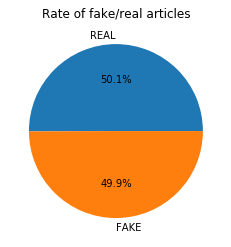

In [6]:
plt.pie(data.label.value_counts().values, labels = data.label.value_counts().index, autopct='%1.1f%%')
plt.title("Rate of fake/real articles")
plt.show()

We can notice that the dataset is nicely balanced.

In [7]:
print("Missing values")
print(data.isnull().sum())

print("\nNumber of text duplicates")
print(data.duplicated(subset=['text']).sum())

print("\nNumber of duplicated titles")
print(data.duplicated(subset=['title']).sum())

print("\nNumber of fully duplicated entries")
print(data.duplicated().sum())


Missing values
title    0
text     0
label    0
dtype: int64

Number of text duplicates
275

Number of duplicated titles
79

Number of fully duplicated entries
29


There are no null values in the dataset. However, there are some duplicate values across the articles texts and titles. Because the text field is the one that contains the most consistent information, I'm going to remove the duplicates in the cleaning step.

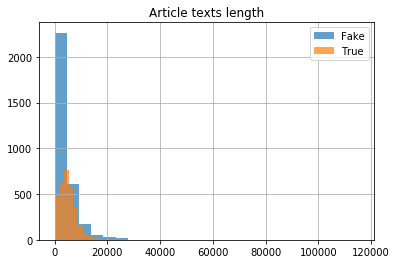

In [8]:
data[data.label == 'FAKE'].text.str.len().hist(label = 'Fake', bins=25, alpha=0.7)
data[data.label == 'REAL'].text.str.len().hist(label = 'True', bins=25, alpha=0.7)

plt.legend(loc='upper right')
plt.title("Article texts length")
plt.show()

Because of the outliers, the plot above is not very suggestive. I'll restrict the horizontal axis between 0 and 40 000. Doing so it's easy to notice that real texts are longer on average.

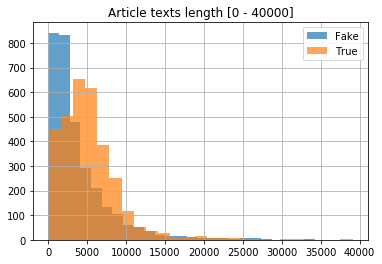

In [9]:
fake_text_len = data[data.label == 'FAKE'].text.str.len()
real_text_len = data[data.label == 'REAL'].text.str.len()

fake_text_len[fake_text_len<40000].hist(label = 'Fake', bins=25, alpha=0.7)
real_text_len[real_text_len<40000].hist(label = 'True', bins=25, alpha=0.7)

plt.legend(loc='upper right')
plt.title("Article texts length [0 - 40000]")
plt.show()

What about news titles? Let's find out :)

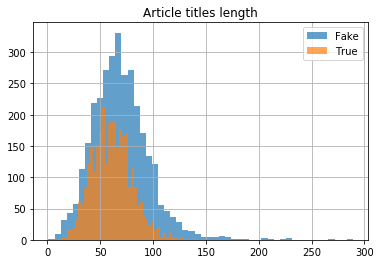

In [10]:
fake_titles_len = data[data.label == 'FAKE'].title.str.len()
real_titles_len = data[data.label == 'REAL'].title.str.len()

fake_titles_len.hist(label='Fake', bins=50, alpha=0.7)
real_titles_len.hist(label='True', bins=50, alpha=0.7)

plt.legend(loc='upper right')
plt.title("Article titles length")
plt.show()

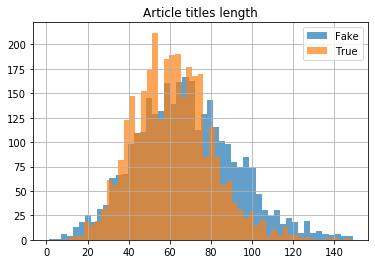

In [11]:
fake_titles_len = data[data.label == 'FAKE'].title.str.len()
real_titles_len = data[data.label == 'REAL'].title.str.len()

fake_titles_len[fake_titles_len<150].hist(label='Fake', bins=50, alpha=0.7)
real_titles_len[real_titles_len<150].hist(label='True', bins=50, alpha=0.7)

plt.legend(loc='upper right')
plt.title("Article titles length")
plt.show()

Title lengths are quite similar for fake and true titles. Fake titles tend to be a bit longer.

In [12]:
data[data.label == 'FAKE'].text.str.len().describe()

count      3164.000000
mean       4121.046460
std        5680.232733
min           1.000000
25%        1283.500000
50%        2558.000000
75%        5027.000000
max      115372.000000
Name: text, dtype: float64

In [13]:
data[data.label == 'REAL'].text.str.len().describe()

count     3171.000000
mean      5292.160202
std       4348.288284
min         43.000000
25%       2729.500000
50%       4683.000000
75%       6829.500000
max      44039.000000
Name: text, dtype: float64

In [14]:
data[data.text.str.len() == 1]

,title,text,label
106,The Arcturian Group by Marilyn Raffaele Octobe...,,FAKE
710,MARKETWATCH LEFTIST: MSM’s “Blatant” Anti Trum...,,FAKE
806,Southern Poverty Law Center Targets Anti-Jihad...,,FAKE
919,Refugee Resettlement Watch: Swept Away In Nort...,,FAKE
940,Michael Bloomberg Names Technological Unemploy...,,FAKE
1664,Alert News : Putins Army Is Coming For World W...,,FAKE
1736,An LDS Reader Takes A Look At Trump Accuser Je...,,FAKE
1851,America’s Senator Jeff Sessions Warns of Worse...,,FAKE
1883,Paris Migrant Campers Increase after Calais Is...,,FAKE
1941,Putins Army is coming for World war 3 against ...,,FAKE


The dataset contains 36 empty fake articles. However, they have non-empty titles, so I'm not going to remove this entries from the dataset, because I have the option to rely on the text information existing in the title. Between real articles there are no missing texts. The shortest real article has a length of 43 characters.

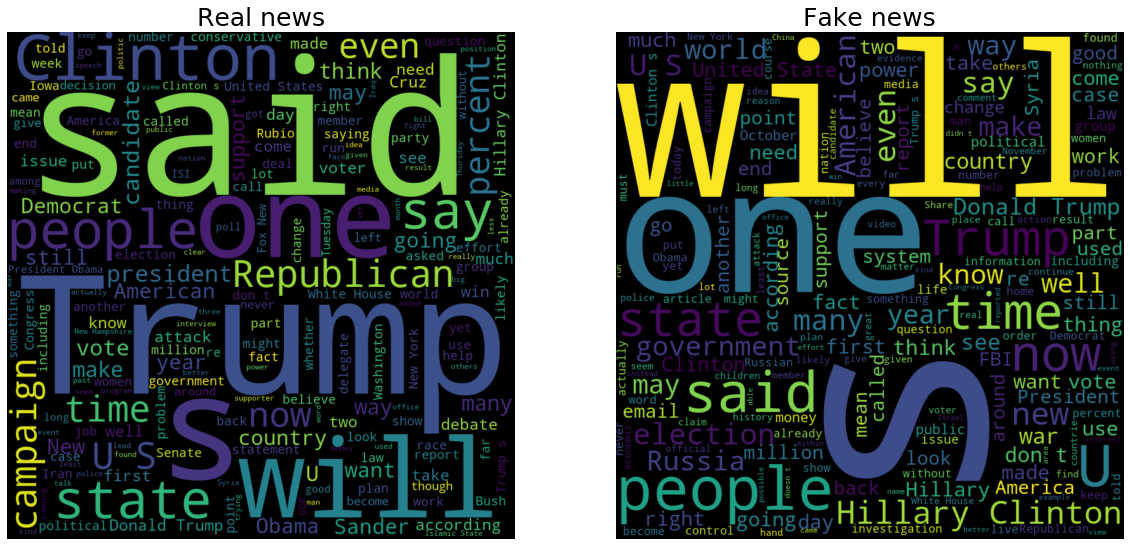

In [15]:
plt.figure(figsize=(20,10))

true_texts_wordcloud = WordCloud(width = 800 , height = 800 , stopwords = STOPWORDS)\
                    .generate(" ".join(data[data.label == 'REAL'].text))
fake_texts_wordcloud = WordCloud(width = 800 , height = 800, stopwords = STOPWORDS)\
                    .generate(" ".join(data[data.label == 'FAKE'].text))

plt.subplot(121)
plt.axis("off")
plt.title('Real news', fontdict={'fontsize': 25})
plt.imshow(true_texts_wordcloud, interpolation='bilinear')

plt.subplot(122)
plt.axis("off")
plt.title('Fake news', fontdict={'fontsize': 25})
plt.imshow(fake_texts_wordcloud, interpolation='bilinear')

plt.show()

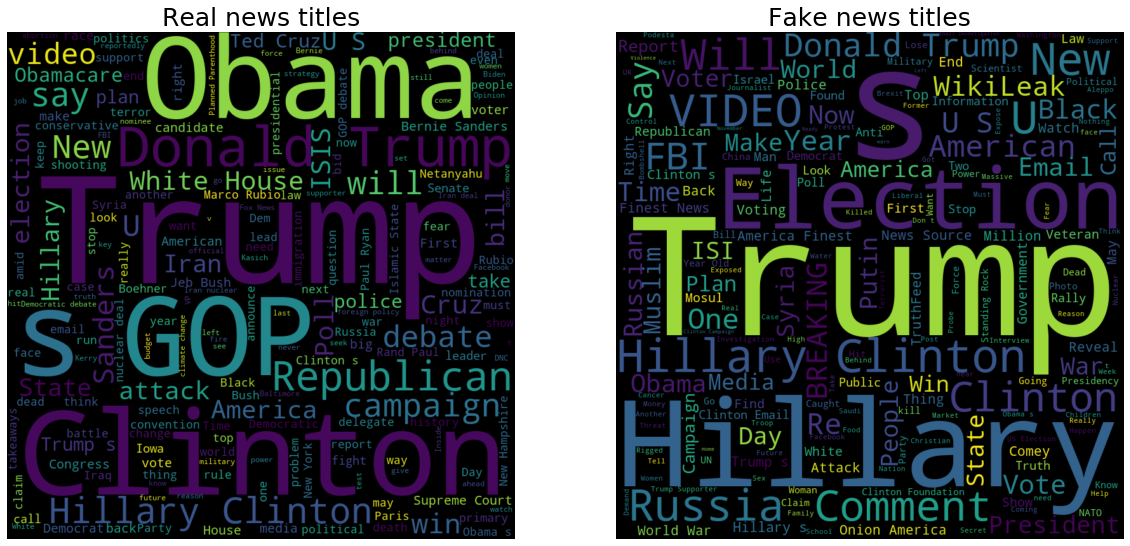

In [16]:
plt.figure(figsize=(20,10))

true_titles_wordcloud = WordCloud(width = 800 , height = 800 , stopwords = STOPWORDS)\
                    .generate(" ".join(data[data.label == 'REAL'].title))
fake_titles_wordcloud = WordCloud(width = 800 , height = 800, stopwords = STOPWORDS)\
                    .generate(" ".join(data[data.label == 'FAKE'].title))

plt.subplot(121)
plt.axis("off")
plt.title('Real news titles', fontdict={'fontsize': 25})
plt.imshow(true_titles_wordcloud, interpolation='bilinear')

plt.subplot(122)
plt.axis("off")
plt.title('Fake news titles', fontdict={'fontsize': 25})
plt.imshow(fake_titles_wordcloud, interpolation='bilinear')

plt.show()

Once again, this fake news dataset is focused on geopolical news, mostly related to USA politics. I've read some researchers statements which were emphasizing that most of the available datasets for fake news detection are focused more on the geopolitical area, and not so much on sports, technology, entertainment etc. Even fact-checking websites are failing to generalize to other topics. Probably this happens because the spread of political fake news proved to have very important and dangerous consequences in our society and nowadays they require a lot more attention, taking their impact into consideration.

In [17]:
fake_titles_corpus = data[data.label == 'FAKE'].title.str.cat(sep=' ')
fake_text_corpus = data[data.label == 'FAKE'].text.str.cat(sep=' ')
fake_corpus = fake_titles_corpus + ' ' + fake_text_corpus

real_titles_corpus = data[data.label == 'REAL'].title.str.cat(sep=' ')
real_text_corpus = data[data.label == 'REAL'].text.str.cat(sep=' ')
real_corpus = real_titles_corpus + ' ' + real_text_corpus

In [18]:
stop = set(stopwords.words('english') + list(string.punctuation))

fake_corpus = fake_corpus.lower()
fake_tokens = [token for token in word_tokenize(fake_corpus) if token not in stop and token.isalnum()]

real_corpus = real_corpus.lower()
real_tokens = [token for token in word_tokenize(real_corpus) if token not in stop and token.isalnum()]

In [19]:
top20_fake_bigrams = pd.Series(bigrams(fake_tokens)).value_counts().head(20)
top20_real_bigrams = pd.Series(bigrams(real_tokens)).value_counts().head(20)

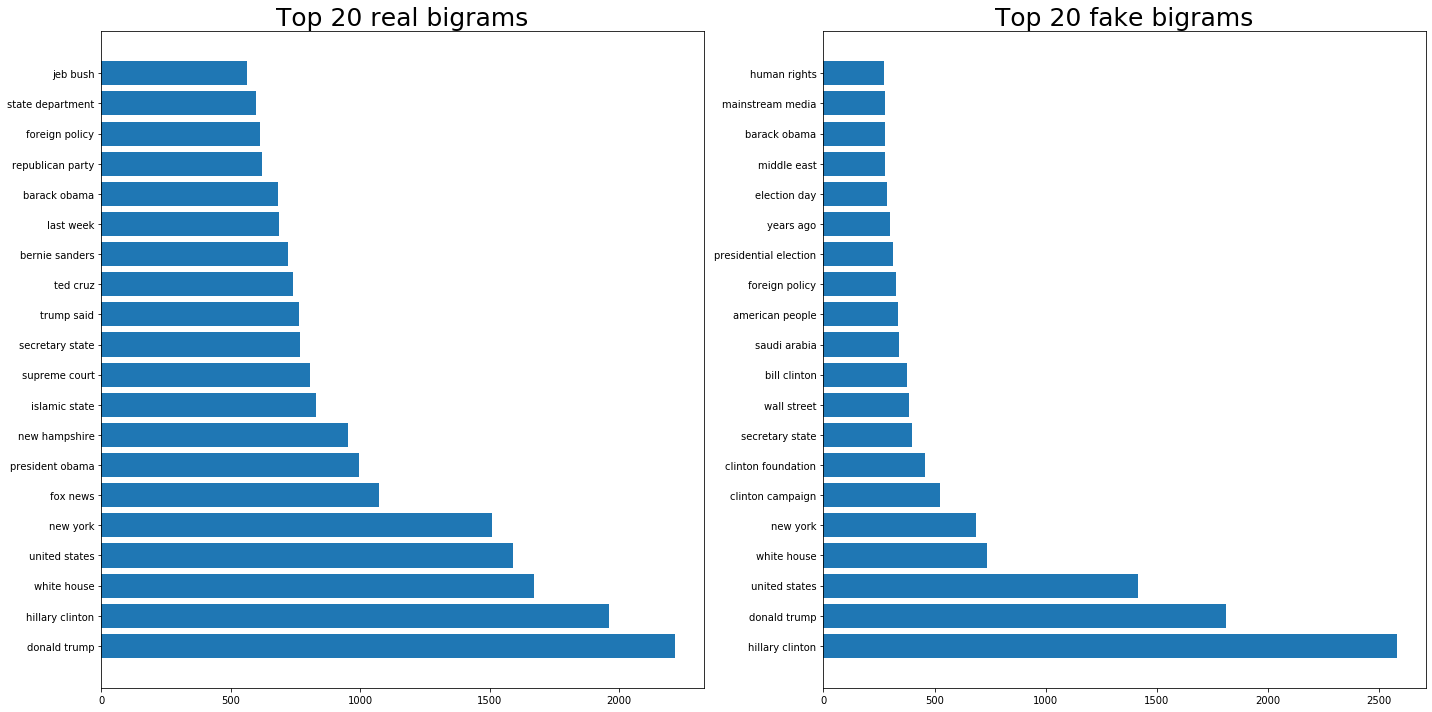

In [20]:
plt.figure(figsize=(20,10))

plt.subplot(121)
plt.title('Top 20 real bigrams', fontdict={'fontsize': 25})
plt.barh([' '.join(bigram) for bigram in top20_real_bigrams.index], list(top20_real_bigrams))

plt.subplot(122)
plt.title('Top 20 fake bigrams', fontdict={'fontsize': 25})
plt.barh([' '.join(bigram) for bigram in top20_fake_bigrams.index], list(top20_fake_bigrams))

plt.tight_layout()
plt.show()

In [21]:
top20_fake_trigrams = pd.Series(trigrams(fake_tokens)).value_counts().head(20)
top20_real_trigrams = pd.Series(trigrams(real_tokens)).value_counts().head(20)

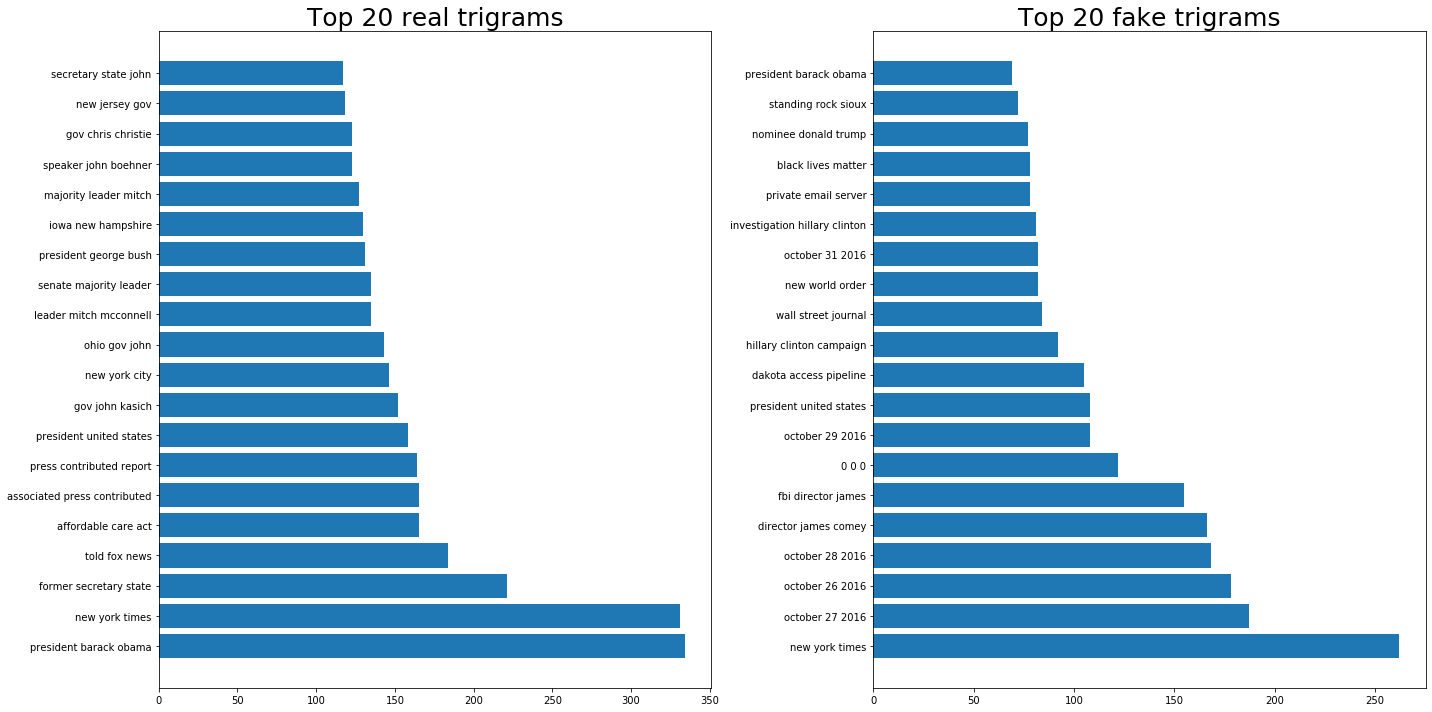

In [22]:
plt.figure(figsize=(20,10))

plt.subplot(121)
plt.title('Top 20 real trigrams', fontdict={'fontsize': 25})
plt.barh([' '.join(trigram) for trigram in top20_real_trigrams.index], list(top20_real_trigrams))

plt.subplot(122)
plt.title('Top 20 fake trigrams', fontdict={'fontsize': 25})
plt.barh([' '.join(trigram) for trigram in top20_fake_trigrams.index], list(top20_fake_trigrams))

plt.tight_layout()
plt.show()

Being able to see the most common bigrams and trigrams enable us to find out more about the type of information these real and fake articles talk about. It is very much clear that the main subject lies in the area of US 2016 presidential elections. One can notice that there are quite a few common bigrams in true and fake articles. Most of them revolve around the main actors of those times: Donald Trump, Hillary Clinton, Barack Obama, White House etc.  
<br/>
Things change a bit when it comes to trigrams. The similarities between the 2 lists are not that many. It's interesting to notice that in the list of fake news trigrams, 5 of them refer to a series of (almost) consecutive days (26-31 oct 2016) which is surely related to the presidential elections that were held on Nov 8.


In [23]:
data[data['label'] == 'FAKE']['text'].apply(lambda x: sum(1 for c in x if c.isupper())).describe()

count    3164.000000
mean      148.381163
std       204.935268
min         0.000000
25%        49.000000
50%        97.000000
75%       176.000000
max      3891.000000
Name: text, dtype: float64

In [24]:
data[data['label'] == 'REAL']['text'].apply(lambda x: sum(1 for c in x if c.isupper())).describe()

count    3171.000000
mean      159.143173
std       144.365354
min         1.000000
25%        81.000000
50%       136.000000
75%       201.000000
max      1523.000000
Name: text, dtype: float64

In [25]:
mean_uppercase_fake = data[data['label'] == 'FAKE']['text'].apply(lambda x: sum(1 for c in x if c.isupper())).mean()
mean_fake_text_len = data[data.label == 'FAKE'].text.str.len().mean()

mean_uppercase_real = data[data['label'] == 'REAL']['text'].apply(lambda x: sum(1 for c in x if c.isupper())).mean()
mean_real_text_len = data[data.label == 'REAL'].text.str.len().mean()

print("Average ratio of uppercase letters in fake texts: {:.4f}".format(mean_uppercase_fake/mean_fake_text_len))
print("Average ratio of uppercase letters in real texts: {:.4f}".format(mean_uppercase_real/mean_real_text_len))

Average ratio of uppercase letters in fake texts: 0.0360
Average ratio of uppercase letters in real texts: 0.0301


When exploring the previous dataset I noticed that fake news articles tend to have more uppercase characters, which made sense, since one expects fake news to use different strategies to capture readers attention. This is why I didn't lowercase the tokens when preparing the data for training.  
For the current dataset the proportion of uppercase letters in fake articles (taking into account the text length) is not crucially different from the propotion of uppercase letters in real articles. 